In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pretrainedmodels

     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e2bc19f33ea50c48f36c22c743835bb73d52c18fda26a310e5198a3ddf106da6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import torch
import time
import keras
import pretrainedmodels
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


from tqdm import tqdm
from glob import glob
from imutils import paths

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark = True

In [4]:
def get_device():
  device = 'cpu'

  if torch.cuda.is_available():
    device = 'cuda'

  return device

print(get_device())

cuda


In [5]:
class ResNet50(nn.Module):
    def __init__(self, encode, dataset, pretrained):
        super(ResNet50, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        
        if dataset == 'caltech':
          n_classes = len(encode.classes_)
        else:
          n_classes = encode
        self.l0 = nn.Linear(2048, n_classes)
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

In [6]:
# custom dataset
class PrepareDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [7]:
class ImageUtils:
  def __init__(self, train_path, test_path):
    self.train_path = train_path
    self.test_path = test_path

  def prepare_data(self, mode='train', dataset_type='caltech'):
    if dataset_type == 'cifar':
      return torchvision.datasets.CIFAR10(root='./data', train=(mode=='train'),
                                        download=True, transform=self.get_normal_transforms())
    if mode == 'train':
      data_path = self.train_path
    else:
      data_path = self.test_path

    image_data = []
    image_label = []

    for image in tqdm(data_path):
      label = image.split(os.path.sep)[-2]

      if label == 'BACKGROUND_Google':
        continue
      if label == 'clutter':
        continue

      image_label.append(label)
      data = cv2.imread(image) 

      #resizing image
      width = int(data.shape[1] * 70 / 100)
      height = int(data.shape[0] * 70 / 100)
      dim = (width, height)
      data = cv2.resize(data, dim, interpolation = cv2.INTER_AREA)

      data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
      image_data.append(data)

    image_data = np.array(image_data)
    image_label = np.array(image_label)

    return image_data, image_label

  def get_transforms(self):
    return transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
    
  def get_normal_transforms(self):
    return transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [15]:
class Knowledge:
  def __init__(self, model, device, dataset):
    self.model = model
    self.optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # loss function
    self.criterion = nn.CrossEntropyLoss()
    self.device = device
    self.dataset = dataset

  def fit(self, data_loader, n_train):
    print('Training')
    self.model.train()
    run_loss = 0.0
    run_correct = 0
    for i, data in tqdm(enumerate(data_loader), total = int(n_train/data_loader.batch_size)):
        if self.dataset == 'caltech':
          inputs, target = data[0].to(self.device), data[1].to(self.device)
        else:
          inputs, target = data[0].to(self.device), torch.tensor(to_categorical(data[1], 10)).to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        labels = torch.max(target, 1)[1]
        loss = self.criterion(outputs, labels)
        run_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        run_correct += (preds == labels).sum().item()
        loss.backward()
        self.optimizer.step()
        
    loss = run_loss/len(data_loader.dataset)
    accuracy = 100. * run_correct/len(data_loader.dataset)
    
    print(f"Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.2f}%")
    
    return loss, accuracy

  def validate(self, data_loader, n_val):
    print('Validating')
    self.model.eval()
    run_loss = 0.0
    run_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader), total=int(n_val/data_loader.batch_size)):
            inputs, target = data[0].to(self.device), data[1].to(self.device)
            outputs = self.model(inputs)
            labels = torch.max(target, 1)[1]
            loss = self.criterion(outputs, labels)
            run_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            run_correct += (preds == labels).sum().item()
        
        loss = run_loss/len(data_loader.dataset)
        accuracy = 100. * run_correct/len(data_loader.dataset)
        print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.2f}%')
        
        return loss, accuracy

  def train(self, n_epochs, dataloader_train, dataloader_val, n_train, n_val):
    train_loss = [] 
    train_acc = []
    val_loss = []
    val_acc = []
    start = time.time()
    print("\nTraining Starts Here....")
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1} of {n_epochs}")
        train_epoch_loss, train_epoch_accuracy = self.fit(dataloader_train, n_train)
        if self.dataset == 'caltech':
          val_epoch_loss, val_epoch_accuracy = self.validate(dataloader_val, n_val)
          val_loss.append(val_epoch_loss)
          val_acc.append(val_epoch_accuracy)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_accuracy)
    end = time.time()
    print("\nTraining Ended Here!!!!")
    print((end-start)/60, 'minutes')
    return train_loss, train_acc, val_loss, val_acc


  def plot_graph(self, train, val, label):
    plt.figure(figsize=(10, 7))
    if label == 'accuracy':
      l1 = 'training accuracy'
      l2 = 'validation accuracy'
      y = 'Accuracy'
    else:
      l1 = 'training loss'
      l2 = 'validation loss'
      y = 'Loss'

    plt.plot(train, color='green', label = l1)
    plt.plot(val, color='blue', label = l2)
    plt.xlabel('Epochs')
    plt.ylabel(y)
    plt.legend()
    
  def test(self, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, target = data[0].to(self.device), data[1].to(self.device)
            outputs = self.model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            if self.dataset == 'caltech':
              labels = torch.max(target, 1)[1]
            else:
              labels = target
            total += target.size(0)
            correct += (predicted == labels).sum().item()
    return correct, total


In [9]:
def execute(train_dir, test_dir):
  train_path = list(paths.list_images(train_dir))
  test_path = list(paths.list_images(test_dir))

  device = get_device()
  n_epochs = 5
  print("\nRunning with {}".format(device))

  image_utils = ImageUtils(train_path, test_path)

  print("\nReading training images..")
  X_train, y_train = image_utils.prepare_data(mode='train')
  
  print("\nReading test images..")
  X_test, y_test = image_utils.prepare_data(mode='test')

  encode = LabelBinarizer()

  y_train = encode.fit_transform(y_train)
  y_test = encode.fit_transform(y_test)

  (X_train, X_val , y_train, y_val) = train_test_split(X_train, y_train, 
                                                    test_size=0.2,  
                                                    stratify=y_train,
                                                    random_state=42)
  
  print("\nDimension of Training, Validation and Test Data")
  print("x_train samples: ", X_train.shape)
  print("x_test samples: ", X_test.shape)
  print("x_val samples: ", X_val.shape)

  #Dataset with transforms
  transform = image_utils.get_transforms()
  train_data = PrepareDataset(X_train, y_train, transform)
  val_data = PrepareDataset(X_val, y_val, transform)
  test_data = PrepareDataset(X_test, y_test, transform)

  # dataloaders
  dataloader_train = DataLoader(train_data, batch_size = 64, shuffle=True)
  dataloader_val = DataLoader(val_data, batch_size = 64, shuffle=True)
  dataloader_test = DataLoader(test_data, batch_size = 64, shuffle=False)

  resnet_model_cal = ResNet50(encode, 'caltech', pretrained=True).to(device)
  network_knowledge = Knowledge(resnet_model_cal, device, 'caltech')

  #training
  train_loss, train_accuracy, val_loss, val_accuracy = network_knowledge.train(n_epochs, dataloader_train, dataloader_val, len(train_data), len(val_data))

  #plotting accuracy and loss
  network_knowledge.plot_graph(train_accuracy, val_accuracy, label = 'accuracy')
  network_knowledge.plot_graph(train_loss, val_loss, label = 'loss')
  
  #testing
  print("\nTesting Starts Here....")
  correct, total = network_knowledge.test(dataloader_test)
  print('\nAccuracy of the network on test images: %0.3f %%' % (100 * correct / total))

In [17]:
def execute_cifar():
  batch_size = 128
  image_utils = ImageUtils(None, None)
  dataset_train = image_utils.prepare_data(mode='train', dataset_type='cifar')
  dataset_test = image_utils.prepare_data(mode='test', dataset_type='cifar')

  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
  
  n_classes = 10
  device = get_device()
  n_epochs = 20
  resnet_model_cifar = ResNet50(n_classes, 'cifar', True).to(device)
  network_knowledge = Knowledge(resnet_model_cifar, device, 'cifar')

  #training
  train_loss, train_accuracy, val_loss, val_accuracy = network_knowledge.train(n_epochs, dataloader_train, None, len(dataset_train), 0)

  #plotting accuracy and loss
  network_knowledge.plot_graph(train_accuracy, val_accuracy, label = 'accuracy')
  network_knowledge.plot_graph(train_loss, val_loss, label = 'loss')
  
  #testing
  print("\nTesting Starts Here....")
  correct, total = network_knowledge.test(dataloader_test)
  print('\nAccuracy of the network on test images: %0.3f %%' % (100 * correct / total))

Streaming output truncated to the last 5000 lines.
  inflating: 256_ObjectCategories_output/Test/010.beer-mug/010_0082.jpg  
  inflating: 256_ObjectCategories_output/Test/010.beer-mug/010_0066.jpg  
  inflating: 256_ObjectCategories_output/Test/010.beer-mug/010_0084.jpg  
  inflating: 256_ObjectCategories_output/Test/010.beer-mug/010_0013.jpg  
  inflating: 256_ObjectCategories_output/Test/010.beer-mug/010_0079.jpg  
  inflating: 256_ObjectCategories_output/Test/109.hot-tub/109_0114.jpg  
  inflating: 256_ObjectCategories_output/Test/010.beer-mug/010_0027.jpg  
  inflating: 256_ObjectCategories_output/Test/109.hot-tub/109_0063.jpg  
  inflating: 256_ObjectCategories_output/Test/109.hot-tub/109_0143.jpg  
  inflating: 256_ObjectCategories_output/Test/126.ladder/126_0108.jpg  
  inflating: 256_ObjectCategories_output/Test/109.hot-tub/109_0005.jpg  
  inflating: 256_ObjectCategories_output/Test/109.hot-tub/109_0153.jpg  
  inflating: 256_ObjectCategories_output/Test/152.owl/152_0084.jpg  

100%|██████████| 3060/3060 [00:07<00:00, 434.29it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Reading test images..


100%|██████████| 6084/6084 [00:13<00:00, 464.52it/s]



Dimension of Training, Validation and Test Data
x_train samples:  (2424,)
x_test samples:  (5647,)
x_val samples:  (606,)

Training Starts Here....
Epoch 1 of 5
Training


38it [01:07,  1.77s/it]


Training Loss: 0.0598, Training Accuracy: 29.62%
Validating


10it [00:06,  1.48it/s]


Validation Loss: 0.0397, Validation Accuracy: 72.44%
Epoch 2 of 5
Training


38it [00:55,  1.45s/it]


Training Loss: 0.0272, Training Accuracy: 83.83%
Validating


10it [00:06,  1.61it/s]


Validation Loss: 0.0207, Validation Accuracy: 86.30%
Epoch 3 of 5
Training


38it [00:55,  1.45s/it]


Training Loss: 0.0097, Training Accuracy: 95.46%
Validating


10it [00:05,  1.94it/s]


Validation Loss: 0.0116, Validation Accuracy: 91.75%
Epoch 4 of 5
Training


38it [00:54,  1.44s/it]


Training Loss: 0.0033, Training Accuracy: 99.01%
Validating


10it [00:05,  1.95it/s]


Validation Loss: 0.0085, Validation Accuracy: 91.25%
Epoch 5 of 5
Training


38it [00:54,  1.44s/it]


Training Loss: 0.0014, Training Accuracy: 99.88%
Validating


10it [00:05,  1.95it/s]


Validation Loss: 0.0076, Validation Accuracy: 91.42%

Training Ended Here!!!!
5.260380140940348 minutes

Testing Starts Here....

Accuracy of the network on test images: 95.537 %

Running with cuda

Reading training images..


100%|██████████| 7710/7710 [00:37<00:00, 204.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Reading test images..


100%|██████████| 22904/22904 [02:01<00:00, 187.75it/s]



Dimension of Training, Validation and Test Data
x_train samples:  (6168,)
x_test samples:  (22904,)
x_val samples:  (1542,)

Training Starts Here....
Epoch 1 of 5
Training


97it [02:28,  1.53s/it]


Training Loss: 0.0746, Training Accuracy: 16.73%
Validating


25it [00:14,  1.70it/s]


Validation Loss: 0.0548, Validation Accuracy: 47.28%
Epoch 2 of 5
Training


97it [02:22,  1.47s/it]


Training Loss: 0.0422, Training Accuracy: 57.23%
Validating


25it [00:13,  1.84it/s]                        


Validation Loss: 0.0345, Validation Accuracy: 63.10%
Epoch 3 of 5
Training


97it [02:23,  1.48s/it]


Training Loss: 0.0216, Training Accuracy: 81.00%
Validating


25it [00:13,  1.84it/s]                        


Validation Loss: 0.0264, Validation Accuracy: 68.81%
Epoch 4 of 5
Training


97it [02:23,  1.48s/it]


Training Loss: 0.0100, Training Accuracy: 92.44%
Validating


25it [00:13,  1.80it/s]


Validation Loss: 0.0235, Validation Accuracy: 68.87%
Epoch 5 of 5
Training


97it [02:27,  1.52s/it]


Training Loss: 0.0044, Training Accuracy: 97.97%
Validating


25it [00:14,  1.75it/s]                        


Validation Loss: 0.0213, Validation Accuracy: 73.22%

Training Ended Here!!!!
13.25124762058258 minutes

Testing Starts Here....

Accuracy of the network on test images: 73.655 %
Files already downloaded and verified
Files already downloaded and verified

Training Starts Here....
Epoch 1 of 20
Training


391it [00:55,  7.09it/s]

Training Loss: 0.0074, Training Accuracy: 66.82%
Epoch 2 of 20
Training



391it [00:55,  7.08it/s]

Training Loss: 0.0034, Training Accuracy: 85.21%
Epoch 3 of 20
Training



391it [00:55,  7.06it/s]

Training Loss: 0.0019, Training Accuracy: 91.49%
Epoch 4 of 20
Training



391it [00:55,  7.06it/s]

Training Loss: 0.0013, Training Accuracy: 94.36%
Epoch 5 of 20
Training



391it [00:55,  7.08it/s]

Training Loss: 0.0009, Training Accuracy: 96.16%
Epoch 6 of 20
Training



391it [00:55,  7.07it/s]

Training Loss: 0.0007, Training Accuracy: 97.11%
Epoch 7 of 20
Training



391it [00:54,  7.11it/s]

Training Loss: 0.0006, Training Accuracy: 97.53%
Epoch 8 of 20
Training



391it [00:55,  7.09it/s]

Training Loss: 0.0005, Training Accuracy: 97.73%
Epoch 9 of 20
Training



391it [00:55,  7.08it/s]

Training Loss: 0.0004, Training Accuracy: 98.17%
Epoch 10 of 20
Training



391it [00:54,  7.11it/s]

Training Loss: 0.0004, Training Accuracy: 98.19%
Epoch 11 of 20
Training



391it [00:54,  7.11it/s]

Training Loss: 0.0004, Training Accuracy: 98.40%
Epoch 12 of 20
Training



391it [01:07,  5.83it/s]

Training Loss: 0.0003, Training Accuracy: 98.68%
Epoch 13 of 20
Training



391it [01:08,  5.70it/s]

Training Loss: 0.0003, Training Accuracy: 98.64%
Epoch 14 of 20
Training



391it [01:10,  5.57it/s]

Training Loss: 0.0003, Training Accuracy: 98.77%
Epoch 15 of 20
Training



391it [00:55,  7.10it/s]

Training Loss: 0.0003, Training Accuracy: 98.74%
Epoch 16 of 20
Training



391it [00:54,  7.12it/s]

Training Loss: 0.0002, Training Accuracy: 99.00%
Epoch 17 of 20
Training



391it [00:55,  7.08it/s]

Training Loss: 0.0002, Training Accuracy: 98.97%
Epoch 18 of 20
Training



391it [00:55,  7.08it/s]

Training Loss: 0.0003, Training Accuracy: 98.74%
Epoch 19 of 20
Training



391it [00:55,  7.09it/s]

Training Loss: 0.0003, Training Accuracy: 98.92%
Epoch 20 of 20
Training



391it [00:55,  7.10it/s]

Training Loss: 0.0002, Training Accuracy: 99.18%

Training Ended Here!!!!
19.161292493343353 minutes

Testing Starts Here....



Accuracy of the network on test images: 84.070 %


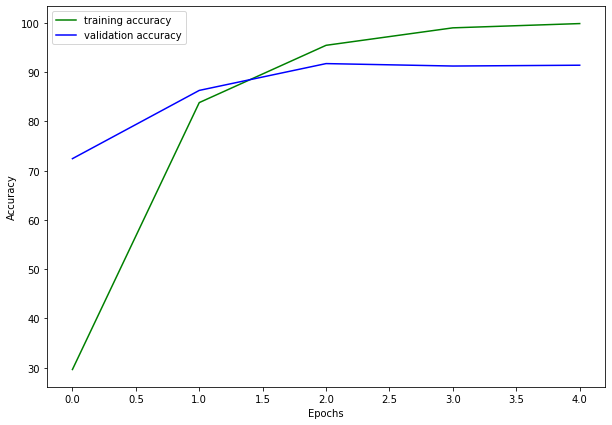

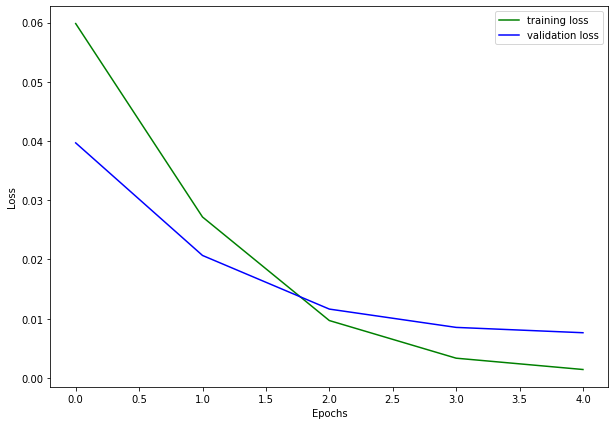

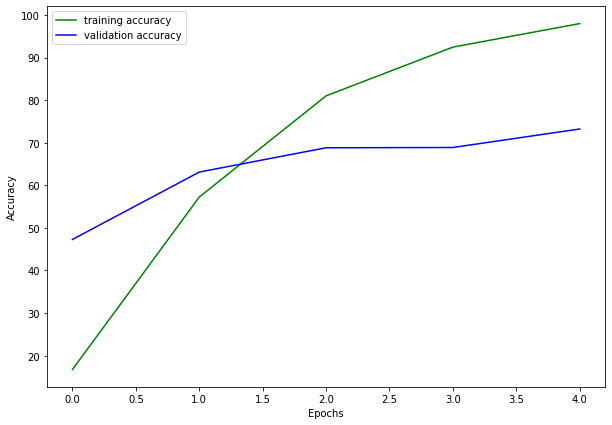

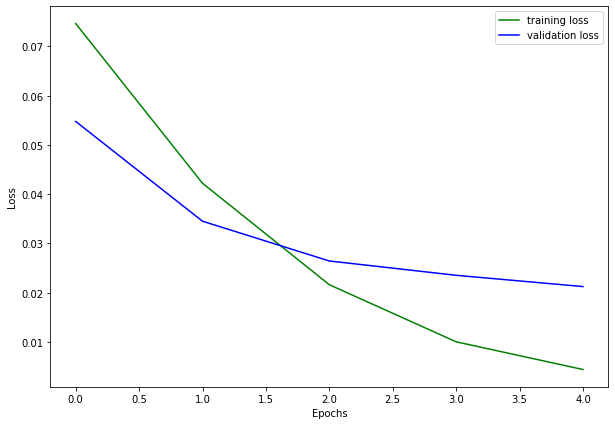

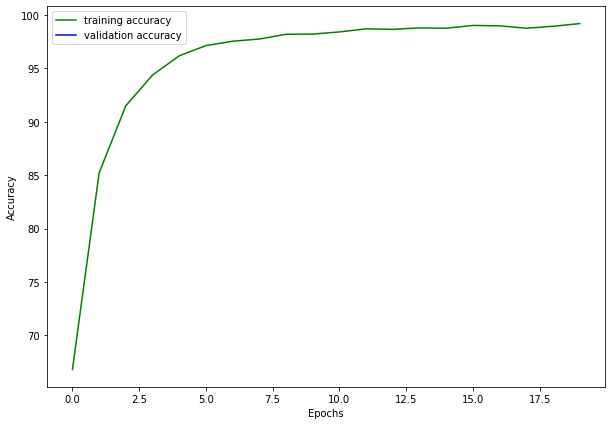

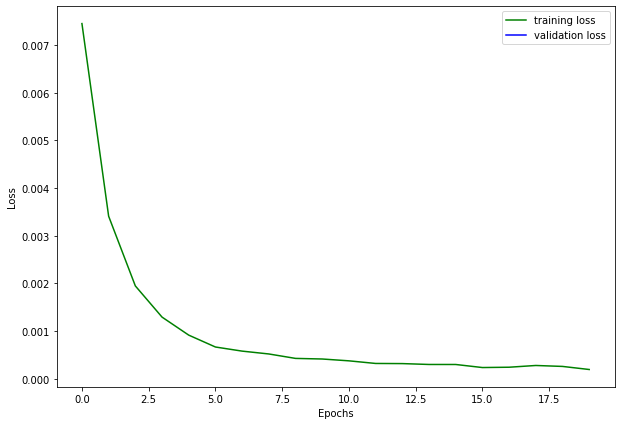

In [19]:
if __name__ == '__main__':

  !unzip drive/My\ Drive/ML/101_ObjectCategories_output.zip 
  train_dir_101 = '101_ObjectCategories_output/Train/'
  test_dir_101 = '101_ObjectCategories_output/Test/'

  !unzip drive/My\ Drive/ML/256_ObjectCategories_output.zip 
  train_dir_256 = '256_ObjectCategories_output/Train/'
  test_dir_256 = '256_ObjectCategories_output/Test/'

  '''EXECUTION:RESNET50 WITH CALTECH101 '''
  print("\nExecution:RESNET50 with Caltech101")
  execute(train_dir_101, test_dir_101)

  '''EXECUTION:RESNET50 WITH CALTECH256 '''
  print("\nExecution:RESNET50 with Caltech256")
  execute(train_dir_256, test_dir_256)

  '''EXECUTION:RESNET50 WITH CIFAR10 '''
  print("\nExecution:RESNET50 with Cifar10")
  execute_cifar()